
# Análise Exploratória e Clusterização dos Episódios de Breaking Bad

Este notebook realiza uma análise exploratória detalhada e aplicação de um modelo de clusterização nos episódios de "Breaking Bad", com o objetivo de entender padrões entre as avaliações e audiências da série. Vamos observar o comportamento dos episódios em relação à sua recepção pelo público e identificar grupos semelhantes.

### Objetivos
- Realizar uma análise exploratória dos dados de episódios.
- Aplicar um modelo de clusterização para agrupar episódios com características semelhantes.
- Interpretar os resultados, visualizando os clusters formados e discutindo o que representam.


In [1]:

# Bibliotecas para análise e manipulação de dados
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Bibliotecas para pré-processamento e modelagem
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Configurações gerais para gráficos
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# Exibir gráfico de forma mais detalhada
import warnings
warnings.filterwarnings("ignore")


In [2]:

# Carregar o dataset e visualizar as primeiras linhas para verificar estrutura e conteúdo
dataset_path = '/content/breaking_bad_tv_show_all_seasons_episodes_data.csv'
df = pd.read_csv(dataset_path, encoding='ISO-8859-1')

# Exibir as primeiras linhas do dataframe para verificar a estrutura dos dados
df.head()


,Date,Season,Episode,Title,Directed by,Written by,Duration_mins,Summary,Rating_IMDB,U.S. viewers_million
0,20-Jan-08,1,1,Pilot,Vince Gilligan,Vince Gilligan,58,"Diagnosed with terminal lung cancer, chemistry...",9.1,1.41
1,27-Jan-08,1,2,Cat's in the Bag...,Adam Bernstein,Vince Gilligan,48,After their first drug deal goes terribly wron...,8.7,1.49
2,10-Feb-08,1,3,...And the Bag's in the River,Adam Bernstein,Vince Gilligan,48,Walt and Jesse clean up after the bathtub inci...,8.8,1.08
3,17-Feb-08,1,4,Cancer Man,Jim McKay,Vince Gilligan,48,Walt tells the rest of his family about his ca...,8.3,1.09
4,24-Feb-08,1,5,Gray Matter,Tricia Brock,"Vince Gilligan, Patty Lin",48,Walt rejects everyone who tries to help him wi...,8.4,0.97



## Exploração Inicial dos Dados

Vamos verificar a estrutura geral do dataset, incluindo o número de colunas, o tipo de cada variável e a presença de valores ausentes. Em seguida, exploramos as variáveis mais detalhadamente para identificar possíveis insights e definir uma estratégia de análise.


In [3]:

# Exibir informações gerais sobre o dataset (tipos de dados, valores ausentes, etc.)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  62 non-null     object 
 1   Season                62 non-null     int64  
 2   Episode               62 non-null     int64  
 3   Title                 62 non-null     object 
 4   Directed by           62 non-null     object 
 5   Written by            62 non-null     object 
 6   Duration_mins         62 non-null     int64  
 7   Summary               62 non-null     object 
 8   Rating_IMDB           62 non-null     float64
 9   U.S. viewers_million  57 non-null     float64
dtypes: float64(2), int64(3), object(5)
memory usage: 5.0+ KB


In [4]:

# Tratamento de valores faltantes:
# Preenchendo valores ausentes na coluna 'U.S. viewers_million' com a média
df['U.S. viewers_million'].fillna(df['U.S. viewers_million'].mean(), inplace=True)

# Verificar novamente para garantir que não restaram valores ausentes
df.isnull().sum()


,0
Date,0
Season,0
Episode,0
Title,0
Directed by,0
Written by,0
Duration_mins,0
Summary,0
Rating_IMDB,0
U.S. viewers_million,0


In [5]:

# Estatísticas descritivas para variáveis numéricas
# Incluindo média, mediana, máximo, e desvio padrão
df[['Rating_IMDB', 'U.S. viewers_million', 'Duration_mins']].describe().T


,count,mean,std,min,25%,50%,75%,max
Rating_IMDB,62.0,9.022581,0.511962,7.80,8.7000,8.900,9.450000,10.00
U.S. viewers_million,62.0,2.324386,1.647258,0.97,1.4925,1.765,2.324386,10.28
Duration_mins,62.0,47.919355,2.632074,43.00,47.0000,47.000,48.000000,60.00


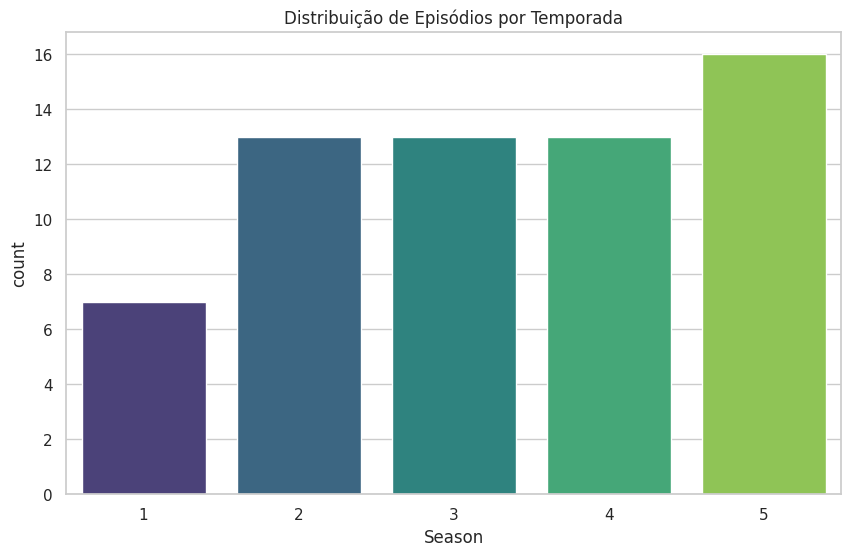

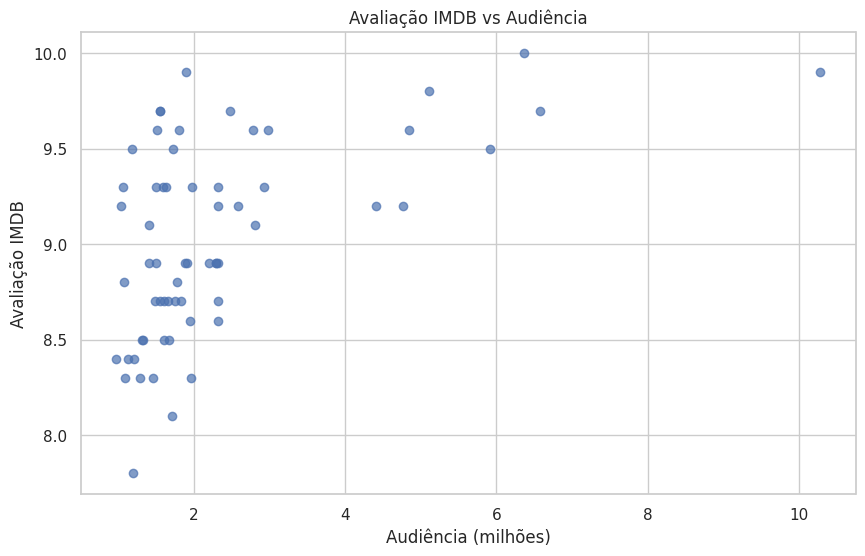

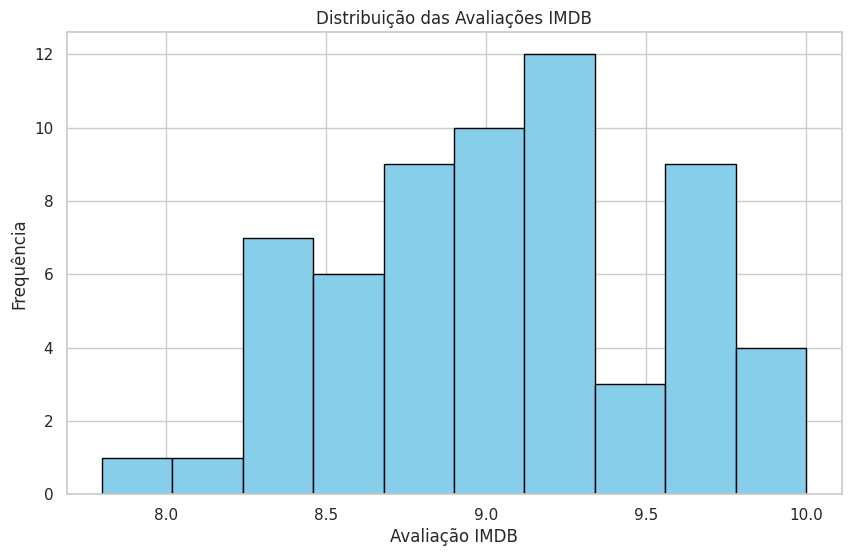

In [9]:

# Visualizações para análise exploratória dos dados
# Gráfico de barras para episódios por temporada
sns.countplot(x='Season', data=df, palette='viridis')
plt.title('Distribuição de Episódios por Temporada')
plt.show()

print()

# Gráfico de dispersão para relação entre audiência e avaliação IMDB
plt.scatter(df['U.S. viewers_million'], df['Rating_IMDB'], alpha=0.7)
plt.title('Avaliação IMDB vs Audiência')
plt.xlabel('Audiência (milhões)')
plt.ylabel('Avaliação IMDB')
plt.show()

print()

# Histograma das avaliações
plt.hist(df['Rating_IMDB'], bins=10, color='skyblue', edgecolor='black')
plt.title('Distribuição das Avaliações IMDB')
plt.xlabel('Avaliação IMDB')
plt.ylabel('Frequência')
plt.show()



## Aplicação do Modelo de Clusterização

Para identificar grupos de episódios semelhantes, aplicaremos a técnica de **K-Means**, que permite agrupar episódios com características numéricas semelhantes. Antes disso, realizamos a padronização das variáveis numéricas para garantir que estejam na mesma escala.


In [10]:

# Padronização das variáveis 'Rating_IMDB' e 'U.S. viewers_million' para clusterização
scaler = StandardScaler()
df[['Rating_scaled', 'Viewers_scaled']] = scaler.fit_transform(df[['Rating_IMDB', 'U.S. viewers_million']])

# Aplicando o K-Means com 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(df[['Rating_scaled', 'Viewers_scaled']])


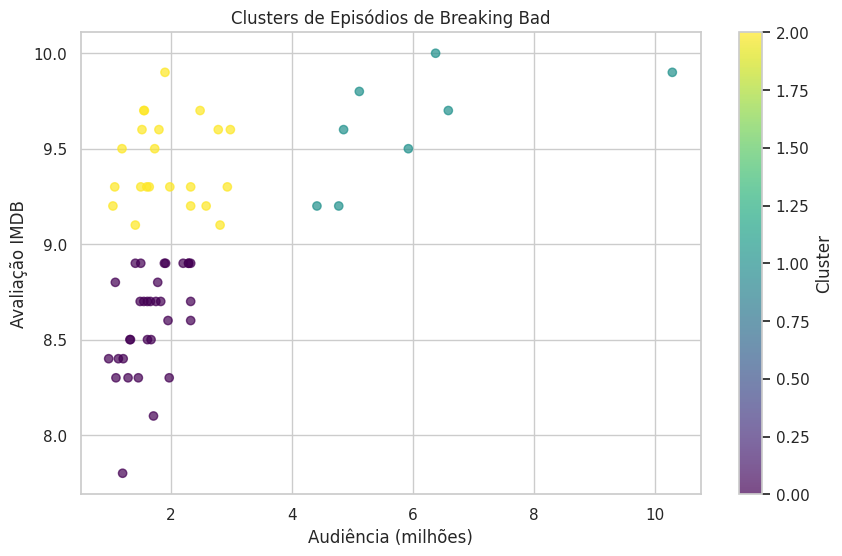

,Rating_IMDB,U.S. viewers_million
Cluster,,
0,8.600000,1.660099
1,9.612500,6.036250
2,9.422727,1.940853


In [11]:

# Visualizando os clusters em um gráfico de dispersão
plt.scatter(df['U.S. viewers_million'], df['Rating_IMDB'], c=df['Cluster'], cmap='viridis', alpha=0.7)
plt.title('Clusters de Episódios de Breaking Bad')
plt.xlabel('Audiência (milhões)')
plt.ylabel('Avaliação IMDB')
plt.colorbar(label='Cluster')
plt.show()

# Análise descritiva dos clusters formados
df.groupby('Cluster')[['Rating_IMDB', 'U.S. viewers_million']].mean()



### Interpretação dos Clusters

Os clusters formados representam três grupos distintos de episódios com base em sua audiência e avaliação IMDB:

- **Cluster 0**: Episódios com audiência e avaliação medianas, sugerindo que são bem recebidos, mas sem destaque significativo.
- **Cluster 1**: Os episódios mais bem avaliados e populares, indicando que são amplamente apreciados pelo público, geralmente episódios marcantes na trama.
- **Cluster 2**: Episódios com audiência e avaliação mais baixas, possivelmente partes da narrativa com menor impacto.

Essas informações ajudam a entender melhor o que torna um episódio de "Breaking Bad" mais ou menos popular, fornecendo insights sobre a narrativa e a recepção do público.
